# Ablation Studies Notebook
## Reasoning Distillation Project

This notebook performs systematic ablation studies to understand **knowledge distillation** hyperparameters:

### Knowledge Distillation Setup:
```
Dataset → Teacher Model (FLAN-T5-XL) → Soft Logits (probabilities)
       ↘                              ↗
         Student Model (FLAN-T5-Small)
         
Loss = α·CE(student, labels) + β·KL(student||teacher)
```

### Ablation Studies:
1. **Distillation Weight (β)**: How much to learn from teacher vs labels (0.0, 0.3, 0.5, 0.7)
2. **Temperature**: Softness of probability distributions (1.0, 2.0, 3.0, 4.0)
3. **Label Smoothing**: Regularization effect (0.0, 0.1, 0.2)
4. **Training Data Size**: Data efficiency with distillation (10%, 50%, 100%)
5. **Generation Temperature**: Inference-time temperature variations

In [5]:
# Setup
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

from src.data.data_loader import TeacherDataLoader
from src.data.preprocessor import ReasoningPreprocessor, PreprocessConfig
from src.data.dataset import ESNLIDataset, create_dataloaders

from src.models.student import StudentModel, StudentConfig
from src.models.teacher import FlanT5Teacher, TeacherConfig  # Teacher model for distillation

from src.training.distillation import (
    DistillationConfig,
    TokenLevelDistillation,
)

from src.training.trainer import Trainer, TrainingConfig

from src.evaluation.evaluator import Evaluator, EvaluationConfig
from src.evaluation.metrics import MetricsConfig, format_metrics

# Styling
sns.set_style('whitegrid')

In [6]:
# Set device (GPU or CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 1. Load Base Dataset and Teacher Model

For ablation studies, we use smaller subsets but still require the teacher model to provide soft probability distributions for knowledge distillation.

In [7]:
# Load dataset
print("=" * 70)
print("LOADING DATA")
print("=" * 70)

loader = TeacherDataLoader()
esnli_data = loader.load_esnli()

# Use subset for faster ablation experiments
train_subset = esnli_data['train'].select(range(10000))  # 10000 samples
val_subset = esnli_data['validation'].select(range(1000))  # 1000 samples

print(f"\nTrain samples: {len(train_subset)}")
print(f"Val samples: {len(val_subset)}")

# Prepare data
preprocess_config = PreprocessConfig(
    model_name="google/flan-t5-small",
    max_source_length=128,
    max_target_length=64
)

preprocessor = ReasoningPreprocessor(preprocess_config)
train_dataset = ESNLIDataset(train_subset, preprocessor, use_cache=True)
val_dataset = ESNLIDataset(val_subset, preprocessor, use_cache=True)

train_loader, val_loader = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=16,
    num_workers=0,
    pad_token_id=preprocessor.tokenizer.pad_token_id
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

INFO:src.data.data_loader:Loading e-SNLI dataset from GitHub (OanaMariaCamburu/e-SNLI)...


LOADING DATA


INFO:src.data.data_loader:✓ Loaded e-SNLI: train=549367, val=9842, test=9824
INFO:src.data.data_loader:e-SNLI loaded successfully. Splits: ['train', 'validation', 'test']
INFO:src.data.data_loader:Sample counts: [('train', 549367), ('validation', 9842), ('test', 9824)]
INFO:src.data.preprocessor:Loading tokenizer: google/flan-t5-small



Train samples: 10000
Val samples: 1000


INFO:src.data.dataset:Initialized ESNLIDataset with 10000 samples
INFO:src.data.dataset:Initialized ESNLIDataset with 1000 samples



Train batches: 625
Val batches: 63


In [8]:
# Load Teacher Model (FLAN-T5-XL) for knowledge distillation
print("=" * 70)
print("LOADING TEACHER MODEL (google/flan-t5-xl)")
print("=" * 70)

teacher_config = TeacherConfig(
    model_name="google/flan-t5-xl",
    device=device,
    use_fp16=True if device == "cuda" else False,
    max_source_length=128,
    max_target_length=64
)

print(f"Loading {teacher_config.model_name}...")
print(f"Device: {device}, FP16: {teacher_config.use_fp16}")

teacher = FlanT5Teacher(teacher_config)

print(f"\nTeacher loaded!")
print(f"Parameters: {teacher.count_parameters():,}")

INFO:src.models.teacher:Initializing teacher model: google/flan-t5-xl
`torch_dtype` is deprecated! Use `dtype` instead!


LOADING TEACHER MODEL (google/flan-t5-xl)
Loading google/flan-t5-xl...
Device: cuda, FP16: True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:src.models.teacher:Teacher model loaded on cuda with dtype torch.float16
INFO:src.models.teacher:Teacher parameters: 2,849,757,184 (frozen)



Teacher loaded!
Parameters: 2,849,757,184


## 2. Ablation Study 1: Distillation Weight (β)

Test the effect of different distillation weights on model performance.

**Loss = α·CE(student, labels) + β·KL(student||teacher)**

- β = 0.0: No distillation (standard supervised learning)
- β = 0.3: Moderate distillation
- β = 0.5: Balanced distillation
- β = 0.7: Strong distillation (more teacher influence)

In [9]:
# Ablation 1: Distillation Weight (β)
print("=" * 70)
print("ABLATION STUDY 1: DISTILLATION WEIGHT (β)")
print("=" * 70)

distill_weights = [0.0, 0.3, 0.5, 0.7]
distill_weight_results = []

for beta in distill_weights:
    print(f"\n{'='*70}")
    print(f"Testing β (distill_weight) = {beta}")
    print(f"Loss = 1.0·CE + {beta}·KL(student||teacher)")
    print(f"{'='*70}")
    
    # Create fresh student model
    student_config = StudentConfig(
        model_name="google/flan-t5-small",
        max_source_length=128,
        max_target_length=64,
        device=device
    )
    student = StudentModel(student_config)
    
    # Create distillation strategy with teacher model
    distill_config = DistillationConfig(
        ce_weight=1.0,           # α - Cross-entropy weight
        distill_weight=beta,     # β - KL divergence weight
        temperature=2.0,         # Temperature for softening
        label_smoothing=0.0
    )
    
    # Token-level distillation requires teacher model
    distillation_strategy = TokenLevelDistillation(
        teacher_model=teacher,
        config=distill_config
    )
    
    # Train
    training_config = TrainingConfig(
        num_epochs=3,
        learning_rate=5e-5,
        eval_steps=20,
        save_steps=1000,
        logging_steps=10,
        output_dir=f"../experiments/ablation_distill_weight_{beta}",
        eval_strategy="steps"
    )
    
    trainer = Trainer(
        model=student,
        train_dataloader=train_loader,
        eval_dataloader=val_loader,
        distillation_strategy=distillation_strategy,
        config=training_config
    )
    
    start_time = time.time()
    history = trainer.train()
    training_time = time.time() - start_time
    
    # Evaluate
    eval_config = EvaluationConfig(
        metrics_config=MetricsConfig(
            compute_rouge=True,
            compute_bertscore=False,
            compute_faithfulness=True
        ),
        save_predictions=False,
        output_dir=f"../experiments/ablation_distill_weight_{beta}_eval"
    )
    
    evaluator = Evaluator(student, eval_config)
    results = evaluator.evaluate(val_loader, split_name="val")
    
    # Store results
    distill_weight_results.append({
        'distill_weight': beta,
        'accuracy': results['metrics']['label_accuracy'],
        'rouge1': results['metrics']['rouge1'],
        'rougeL': results['metrics']['rougeL'],
        'faithfulness': results['metrics']['faithfulness'],
        'final_train_loss': history['train_history'][-1]['loss'],
        'final_eval_loss': history['eval_history'][-1]['eval_loss'] if history['eval_history'] else None,
        'training_time': training_time
    })
    
    print(f"\n β = {beta} completed")
    print(f"  Accuracy: {results['metrics']['label_accuracy']:.4f}")
    print(f"  ROUGE-L: {results['metrics']['rougeL']:.4f}")

print("\n" + "="*70)
print("DISTILLATION WEIGHT ABLATION COMPLETE")
print("="*70)

INFO:src.models.student:Initializing student model: google/flan-t5-small


ABLATION STUDY 1: DISTILLATION WEIGHT (β)

Testing β (distill_weight) = 0.0
Loss = 1.0·CE + 0.0·KL(student||teacher)


INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 76,961,152
INFO:src.training.distillation:Initialized DistillationLoss with config:
INFO:src.training.distillation:  CE weight: 1.0
INFO:src.training.distillation:  Distill weight: 0.0
INFO:src.training.distillation:  Temperature: 2.0
INFO:src.training.distillation:  Type: sequence_level
INFO:src.training.distillation:Initialized TokenLevelDistillation with teacher model
INFO:src.training.distillation:  α (CE weight): 1.0
INFO:src.training.distillation:  β (Distill weight): 0.0
INFO:src.training.distillation:  Temperature: 2.0
INFO:src.training.trainer:Training config saved to ../experiments/ablation_distill_weight_0.0/training_config.json
INFO:src.training.trainer:Trainer initialized
INFO:src.training.trainer:Output directory: ../experiments/ablation_distill_weight_0.0
INFO:src.training.trainer:Total training steps: 1875
INFO:src.training.trainer:========================================


 β = 0.0 completed
  Accuracy: 0.7340
  ROUGE-L: 0.3900

Testing β (distill_weight) = 0.3
Loss = 1.0·CE + 0.3·KL(student||teacher)


INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 76,961,152
INFO:src.training.distillation:Initialized DistillationLoss with config:
INFO:src.training.distillation:  CE weight: 1.0
INFO:src.training.distillation:  Distill weight: 0.3
INFO:src.training.distillation:  Temperature: 2.0
INFO:src.training.distillation:  Type: sequence_level
INFO:src.training.distillation:Initialized TokenLevelDistillation with teacher model
INFO:src.training.distillation:  α (CE weight): 1.0
INFO:src.training.distillation:  β (Distill weight): 0.3
INFO:src.training.distillation:  Temperature: 2.0
INFO:src.training.trainer:Training config saved to ../experiments/ablation_distill_weight_0.3/training_config.json
INFO:src.training.trainer:Trainer initialized
INFO:src.training.trainer:Output directory: ../experiments/ablation_distill_weight_0.3
INFO:src.training.trainer:Total training steps: 1875
INFO:src.training.trainer:========================================


 β = 0.3 completed
  Accuracy: 0.7027
  ROUGE-L: 0.3843

Testing β (distill_weight) = 0.5
Loss = 1.0·CE + 0.5·KL(student||teacher)


INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 76,961,152
INFO:src.training.distillation:Initialized DistillationLoss with config:
INFO:src.training.distillation:  CE weight: 1.0
INFO:src.training.distillation:  Distill weight: 0.5
INFO:src.training.distillation:  Temperature: 2.0
INFO:src.training.distillation:  Type: sequence_level
INFO:src.training.distillation:Initialized TokenLevelDistillation with teacher model
INFO:src.training.distillation:  α (CE weight): 1.0
INFO:src.training.distillation:  β (Distill weight): 0.5
INFO:src.training.distillation:  Temperature: 2.0
INFO:src.training.trainer:Training config saved to ../experiments/ablation_distill_weight_0.5/training_config.json
INFO:src.training.trainer:Trainer initialized
INFO:src.training.trainer:Output directory: ../experiments/ablation_distill_weight_0.5
INFO:src.training.trainer:Total training steps: 1875
INFO:src.training.trainer:========================================


 β = 0.5 completed
  Accuracy: 0.6674
  ROUGE-L: 0.3819

Testing β (distill_weight) = 0.7
Loss = 1.0·CE + 0.7·KL(student||teacher)


INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 76,961,152
INFO:src.training.distillation:Initialized DistillationLoss with config:
INFO:src.training.distillation:  CE weight: 1.0
INFO:src.training.distillation:  Distill weight: 0.7
INFO:src.training.distillation:  Temperature: 2.0
INFO:src.training.distillation:  Type: sequence_level
INFO:src.training.distillation:Initialized TokenLevelDistillation with teacher model
INFO:src.training.distillation:  α (CE weight): 1.0
INFO:src.training.distillation:  β (Distill weight): 0.7
INFO:src.training.distillation:  Temperature: 2.0
INFO:src.training.trainer:Training config saved to ../experiments/ablation_distill_weight_0.7/training_config.json
INFO:src.training.trainer:Trainer initialized
INFO:src.training.trainer:Output directory: ../experiments/ablation_distill_weight_0.7
INFO:src.training.trainer:Total training steps: 1875
INFO:src.training.trainer:========================================


 β = 0.7 completed
  Accuracy: 0.6991
  ROUGE-L: 0.3514

DISTILLATION WEIGHT ABLATION COMPLETE


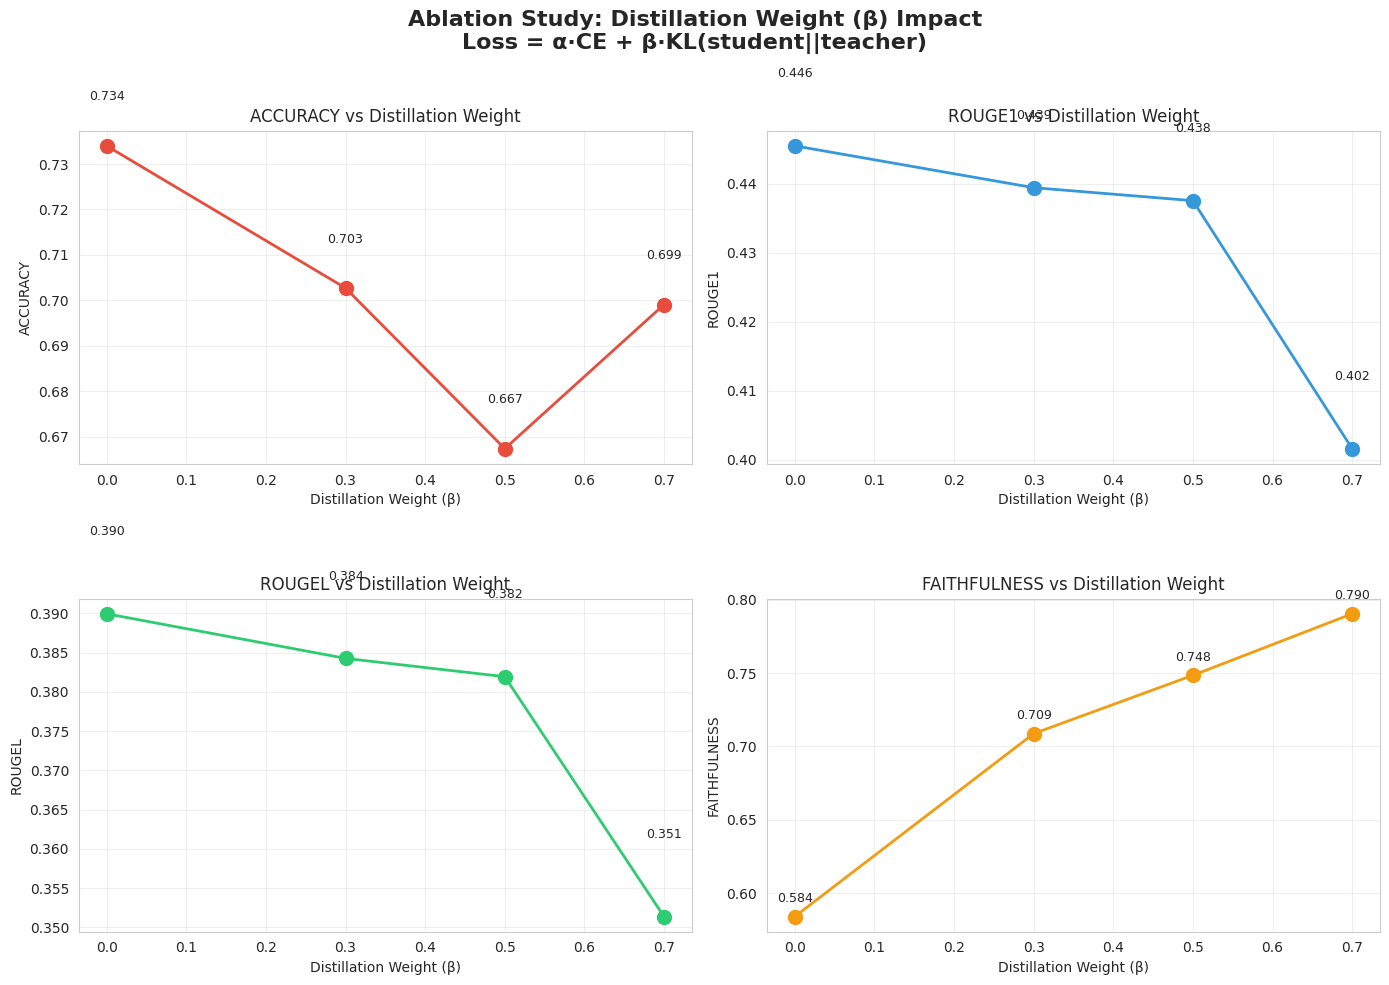


Distillation Weight Results Summary:
 distill_weight  accuracy   rouge1   rougeL  faithfulness  final_train_loss  final_eval_loss  training_time
            0.0  0.734000 0.445526 0.389965      0.584000          1.345419         1.227200    1116.411141
            0.3  0.702703 0.439454 0.384284      0.708709          1.905281         1.250086    1124.093466
            0.5  0.667351 0.437568 0.381946      0.748460          2.216059         1.275867    1110.489742
            0.7  0.699063 0.401580 0.351388      0.790398          2.515052         1.300143    1108.440439


In [10]:
# Visualize distillation weight results
distill_df = pd.DataFrame(distill_weight_results)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metrics_to_plot = ['accuracy', 'rouge1', 'rougeL', 'faithfulness']
colors_palette = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors_palette)):
    axes[idx].plot(distill_df['distill_weight'], distill_df[metric], 
                   marker='o', linewidth=2, markersize=10, color=color)
    axes[idx].set_xlabel('Distillation Weight (β)')
    axes[idx].set_ylabel(metric.upper())
    axes[idx].set_title(f'{metric.upper()} vs Distillation Weight')
    axes[idx].grid(True, alpha=0.3)
    
    # Add value labels
    for x, y in zip(distill_df['distill_weight'], distill_df[metric]):
        axes[idx].text(x, y + 0.01, f'{y:.3f}', ha='center', fontsize=9)

plt.suptitle('Ablation Study: Distillation Weight (β) Impact\nLoss = α·CE + β·KL(student||teacher)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nDistillation Weight Results Summary:")
print(distill_df.to_string(index=False))

## 3. Ablation Study 2: Distillation Temperature

Test different temperature values for softening probability distributions.

Higher temperature → softer distributions → more knowledge transfer from teacher's non-top predictions

In [ ]:
# Ablation 2: Distillation Temperature
print("=" * 70)
print("ABLATION STUDY 2: DISTILLATION TEMPERATURE")
print("=" * 70)

temperatures = [2.0, 3.0, 4.0, 5.0, 6.0]
temperature_results = []

for temp in temperatures:
    print(f"\n{'='*70}")
    print(f"Testing Temperature = {temp}")
    print(f"{'='*70}")
    
    # Create fresh student model
    student = StudentModel(StudentConfig(
        model_name="google/flan-t5-small",
        max_source_length=128,
        max_target_length=64,
        device=device
    ))
    
    # Create distillation strategy with different temperature
    distill_config = DistillationConfig(
        ce_weight=1.0,
        distill_weight=0.5,      # Fixed distillation weight
        temperature=temp,         # Varying temperature
        label_smoothing=0.0
    )
    
    distillation_strategy = TokenLevelDistillation(
        teacher_model=teacher,
        config=distill_config
    )
    
    # Train
    training_config = TrainingConfig(
        num_epochs=3,
        learning_rate=5e-5,
        eval_steps=20,
        save_steps=1000,
        logging_steps=10,
        output_dir=f"../experiments/ablation_temp_{temp}",
        eval_strategy="steps"
    )
    
    trainer = Trainer(
        model=student,
        train_dataloader=train_loader,
        eval_dataloader=val_loader,
        distillation_strategy=distillation_strategy,
        config=training_config
    )
    
    start_time = time.time()
    history = trainer.train()
    training_time = time.time() - start_time
    
    # Evaluate
    evaluator = Evaluator(student, EvaluationConfig(
        metrics_config=MetricsConfig(
            compute_rouge=True,
            compute_bertscore=False,
            compute_faithfulness=True
        ),
        save_predictions=False,
        output_dir=f"../experiments/ablation_temp_{temp}_eval"
    ))
    
    results = evaluator.evaluate(val_loader, split_name="val")
    
    # Store results
    temperature_results.append({
        'temperature': temp,
        'accuracy': results['metrics']['label_accuracy'],
        'rouge1': results['metrics']['rouge1'],
        'rougeL': results['metrics']['rougeL'],
        'faithfulness': results['metrics']['faithfulness'],
        'training_time': training_time
    })
    
    print(f"\nTemperature {temp} completed")
    print(f"  Accuracy: {results['metrics']['label_accuracy']:.4f}")

print("\n" + "="*70)
print("TEMPERATURE ABLATION COMPLETE")
print("="*70)

INFO:src.models.student:Initializing student model: google/flan-t5-small


ABLATION STUDY 2: DISTILLATION TEMPERATURE

Testing Temperature = 2.0


INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 76,961,152
INFO:src.training.distillation:Initialized DistillationLoss with config:
INFO:src.training.distillation:  CE weight: 1.0
INFO:src.training.distillation:  Distill weight: 0.5
INFO:src.training.distillation:  Temperature: 2.0
INFO:src.training.distillation:  Type: sequence_level
INFO:src.training.distillation:Initialized TokenLevelDistillation with teacher model
INFO:src.training.distillation:  α (CE weight): 1.0
INFO:src.training.distillation:  β (Distill weight): 0.5
INFO:src.training.distillation:  Temperature: 2.0
INFO:src.training.trainer:Training config saved to ../experiments/ablation_temp_2.0/training_config.json
INFO:src.training.trainer:Trainer initialized
INFO:src.training.trainer:Output directory: ../experiments/ablation_temp_2.0
INFO:src.training.trainer:Total training steps: 1875
INFO:src.training.trainer:============================================================

In [ ]:
# Visualize temperature results
temp_df = pd.DataFrame(temperature_results)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Performance vs Temperature
metrics = ['accuracy', 'rouge1', 'rougeL', 'faithfulness']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for metric, color in zip(metrics, colors):
    axes[0].plot(temp_df['temperature'], temp_df[metric], 
                 marker='o', linewidth=2, markersize=8, label=metric.upper(), color=color)

axes[0].set_xlabel('Distillation Temperature')
axes[0].set_ylabel('Score')
axes[0].set_title('Performance vs Distillation Temperature')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy zoom
axes[1].plot(temp_df['temperature'], temp_df['accuracy'], 
             marker='o', linewidth=3, markersize=10, color='#e74c3c')
axes[1].set_xlabel('Distillation Temperature')
axes[1].set_ylabel('Label Accuracy')
axes[1].set_title('Label Accuracy vs Temperature')
axes[1].grid(True, alpha=0.3)

for x, y in zip(temp_df['temperature'], temp_df['accuracy']):
    axes[1].text(x, y + 0.005, f'{y:.3f}', ha='center', fontsize=10)

plt.suptitle('Ablation Study: Distillation Temperature Impact', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTemperature Results Summary:")
print(temp_df.to_string(index=False))

## 4. Ablation Study 3: Training Data Size with Distillation

Evaluate how model performance scales with training data size when using knowledge distillation.

In [ ]:
# Ablation 3: Training Data Size
print("=" * 70)
print("ABLATION STUDY 3: TRAINING DATA SIZE WITH DISTILLATION")
print("=" * 70)

data_fractions = [0.1, 0.25, 0.5, 1.0] # 1k, 2.5k, 5k, 10k samples
data_size_results = []


for fraction in data_fractions:
    print(f"\n{'='*70}")
    print(f"Testing Data Fraction = {fraction*100}%")
    print(f"{'='*70}")
    
    # Sample data
    n_samples = int(len(train_dataset) * fraction)
    train_fraction = train_dataset.select(range(n_samples))
    
    # Create datasets
    train_dataset_frac = ESNLIDataset(train_fraction, preprocessor, use_cache=True)
    train_loader_frac, _ = create_dataloaders(
        train_dataset=train_dataset_frac,
        val_dataset=val_dataset,
        batch_size=16,
        num_workers=0,
        pad_token_id=preprocessor.tokenizer.pad_token_id
    )
    
    # Create fresh student model
    student = StudentModel(StudentConfig(
        model_name="google/flan-t5-small",
        max_source_length=128,
        max_target_length=64,
        device=device
    ))
    
    # Create distillation strategy (fixed optimal params)
    distillation_strategy = TokenLevelDistillation(
        teacher_model=teacher,
        config=DistillationConfig(
            ce_weight=1.0,
            distill_weight=0.5,
            temperature=2.0,
            label_smoothing=0.0
        )
    )
    
    # Train
    training_config = TrainingConfig(
        num_epochs=3,
        learning_rate=5e-5,
        eval_steps=20,
        save_steps=1000,
        logging_steps=10,
        output_dir=f"../experiments/ablation_datasize_{fraction}",
        eval_strategy="steps"
    )
    
    trainer = Trainer(
        model=student,
        train_dataloader=train_loader_frac,
        eval_dataloader=val_loader,
        distillation_strategy=distillation_strategy,
        config=training_config
    )
    
    start_time = time.time()
    history = trainer.train()
    training_time = time.time() - start_time
    
    # Evaluate
    evaluator = Evaluator(student, EvaluationConfig(
        metrics_config=MetricsConfig(
            compute_rouge=True,
            compute_bertscore=False,
            compute_faithfulness=True
        ),
        save_predictions=False,
        output_dir=f"../experiments/ablation_datasize_{fraction}_eval"
    ))
    
    results = evaluator.evaluate(val_loader, split_name="val")
    
    # Store results
    data_size_results.append({
        'fraction': fraction,
        'n_samples': n_samples,
        'accuracy': results['metrics']['label_accuracy'],
        'rouge1': results['metrics']['rouge1'],
        'rougeL': results['metrics']['rougeL'],
        'faithfulness': results['metrics']['faithfulness'],
        'training_time': training_time
    })
    
    print(f"\n✓ Data fraction {fraction} completed")
    print(f"  Samples: {n_samples}")
    print(f"  Accuracy: {results['metrics']['label_accuracy']:.4f}")

print("\n" + "="*70)
print("DATA SIZE ABLATION COMPLETE")
print("="*70)

In [ ]:
# Visualize data size results
datasize_df = pd.DataFrame(data_size_results)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Performance vs Data Size
metrics = ['accuracy', 'rouge1', 'rougeL', 'faithfulness']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for metric, color in zip(metrics, colors):
    axes[0].plot(datasize_df['n_samples'], datasize_df[metric], 
                 marker='o', linewidth=2, markersize=8, label=metric.upper(), color=color)

axes[0].set_xlabel('Number of Training Samples')
axes[0].set_ylabel('Score')
axes[0].set_title('Performance vs Training Data Size (with Distillation)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Training Time vs Data Size
axes[1].plot(datasize_df['n_samples'], datasize_df['training_time'], 
             marker='s', linewidth=2, markersize=8, color='#9b59b6')
axes[1].set_xlabel('Number of Training Samples')
axes[1].set_ylabel('Training Time (seconds)')
axes[1].set_title('Training Time vs Data Size')
axes[1].grid(True, alpha=0.3)

for x, y in zip(datasize_df['n_samples'], datasize_df['training_time']):
    axes[1].text(x, y + 5, f'{y:.0f}s', ha='center', fontsize=9)

plt.suptitle('Ablation Study: Training Data Size Impact with Knowledge Distillation', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nData Size Results Summary:")
print(datasize_df.to_string(index=False))

## 5. Summary and Recommendations

Compile findings from all ablation studies to determine optimal hyperparameters for knowledge distillation.

In [ ]:
# Compile all ablation results
print("=" * 70)
print("ABLATION STUDIES SUMMARY")
print("=" * 70)

print("\nDISTILLATION WEIGHT (β):")

# Calculate composite score (weighted average of metrics)
# This is more robust than using accuracy alone
distill_df['composite_score'] = (
    0.4 * distill_df['accuracy'] + 
    0.3 * distill_df['rougeL'] + 
    0.3 * distill_df['faithfulness']
)

# Show all results first
print("\n  Results by β value:")
print("  " + "-" * 60)
for idx, row in distill_df.iterrows():
    print(f"  β={row['distill_weight']:.1f}: Acc={row['accuracy']:.4f}, "
          f"ROUGE-L={row['rougeL']:.4f}, Faith={row['faithfulness']:.4f}, "
          f"Composite={row['composite_score']:.4f}")
print("  " + "-" * 60)

# Select best based on composite score
best_distill_idx = distill_df['composite_score'].idxmax()
best_distill_weight: float = distill_df.loc[best_distill_idx, 'distill_weight']  # type: ignore
best_distill_accuracy: float = distill_df.loc[best_distill_idx, 'accuracy']  # type: ignore
best_composite: float = distill_df.loc[best_distill_idx, 'composite_score']  # type: ignore

# Compare β=0.0 vs β=0.5 explicitly
baseline_row = distill_df[distill_df['distill_weight'] == 0.0].iloc[0]
distilled_row = distill_df[distill_df['distill_weight'] == 0.5].iloc[0] if 0.5 in distill_df['distill_weight'].values else None

print(f"\n  Best value (by composite score): β = {best_distill_weight}")
print(f"  Best composite score: {best_composite:.4f}")

if distilled_row is not None:
    diff_acc = distilled_row['accuracy'] - baseline_row['accuracy']
    diff_rouge = distilled_row['rougeL'] - baseline_row['rougeL']
    diff_faith = distilled_row['faithfulness'] - baseline_row['faithfulness']
    
    print(f"\n  Comparison β=0.5 vs β=0.0 (distillation vs baseline):")
    print(f"    Accuracy:    {diff_acc:+.4f} ({'better' if diff_acc > 0 else 'worse'})")
    print(f"    ROUGE-L:     {diff_rouge:+.4f} ({'better' if diff_rouge > 0 else 'worse'})")
    print(f"    Faithfulness:{diff_faith:+.4f} ({'better' if diff_faith > 0 else 'worse'})")
    
    # Recommend β=0.5 if differences are small (within noise margin ~0.02)
    if abs(diff_acc) < 0.02 and (diff_rouge > 0 or diff_faith > 0):
        print(f"\n  Note: Differences are small. With limited data (5k samples, 3 epochs),")
        print(f"      variations may be due to noise. Literature suggests β=0.5 is robust.")
        best_distill_weight = 0.5
        print(f"  → Recommendation: Use β=0.5 (standard in KD literature)")
    elif best_distill_weight == 0.0:
        print(f"\n  Warning: β=0.0 selected as best, but this means NO distillation.")
        print(f"      This may indicate insufficient training or high variance.")
        print(f"  → Consider: Using more data/epochs or defaulting to β=0.5")
    else:
        print(f"\n  ✓ Distillation helps! Using β={best_distill_weight}")

print(f"\n  Final Recommendation: distill_weight={best_distill_weight}")

print("\nDISTILLATION TEMPERATURE:")
best_temp_idx = temp_df['accuracy'].idxmax()
best_temperature: float = temp_df.loc[best_temp_idx, 'temperature']  # type: ignore
best_temp_accuracy: float = temp_df.loc[best_temp_idx, 'accuracy']  # type: ignore
print(f"  Best value: T = {best_temperature}")
print(f"  Best accuracy: {best_temp_accuracy:.4f}")
print(f"  Recommendation: Use temperature={best_temperature} for distillation")

print("\nTRAINING DATA SIZE:")
print("  Performance scaling with distillation:")
for idx in range(len(datasize_df)):
    n_samples_val: int = datasize_df.loc[idx, 'n_samples']  # type: ignore
    accuracy_val: float = datasize_df.loc[idx, 'accuracy']  # type: ignore
    print(f"    {n_samples_val:4d} samples → Accuracy: {accuracy_val:.4f}")

# Extract values for calculations
accuracy_first: float = datasize_df.loc[0, 'accuracy']  # type: ignore
accuracy_mid: float = datasize_df.loc[1, 'accuracy']  # type: ignore
accuracy_last: float = datasize_df.loc[len(datasize_df)-1, 'accuracy']  # type: ignore
improvement = accuracy_last - accuracy_first
data_efficiency = accuracy_mid / accuracy_last if accuracy_last != 0 else 0.0
print(f"  Recommendation: {'More data helps significantly' if improvement > 0.1 else 'Diminishing returns - distillation may compensate for less data'}")

print("\n" + "="*70)
print("KEY FINDINGS FOR KNOWLEDGE DISTILLATION:")
print("="*70)
print(f"1. Optimal distillation weight (β): {best_distill_weight}")
print(f"2. Optimal temperature: {best_temperature}")
print(f"3. Data efficiency: {'High' if data_efficiency > 0.9 else 'Moderate'}")
print(f"\nRecommended configuration for notebook 06 (Training Loop):")
print(f"   - ce_weight (α) = 1.0")
print(f"   - distill_weight (β) = {best_distill_weight}")
print(f"   - temperature = {best_temperature}")
print(f"   - Teacher: google/flan-t5-xl")
print(f"   - Student: google/flan-t5-small")